# 1. Holt-Winter ETS model - Detailed

### We are here trying the Holt-Winter ETS model for forecast

In [1]:
# List of all Parameters

# Timestamp of when we want to start the prediction
target_start = "9:00:00"

# n-1 minutes before the target date and n min after
time_variation = 30

## I. Loading libraries and the sample dataset

In [2]:
# Library Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
# Loading from github the dataset. It is an extract of the madeleine station only

df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")
df_station.head()

,Unnamed: 0,availiable_docks,date,weekday,hour
0,0,8,2020-01-15 10:17:00,Wednesday,10
1,1,8,2020-01-15 10:18:00,Wednesday,10
2,2,7,2020-01-15 10:19:00,Wednesday,10
3,3,8,2020-01-15 10:20:00,Wednesday,10
4,4,8,2020-01-15 10:21:00,Wednesday,10


## II. Preprocessing of the data

### A. Restraining the dataset over a time periode

In [4]:
# Removing first not useless column
df_station.pop("Unnamed: 0")

# Adding day and minute
df_station["day"] = df_station.date.apply(lambda x: x[:10])

# Converting to datetime the number of availiable docks
df_station['date'] = pd.to_datetime(df_station['date'])

df_station.head()

,availiable_docks,date,weekday,hour,day
0,8,2020-01-15 10:17:00,Wednesday,10,2020-01-15
1,8,2020-01-15 10:18:00,Wednesday,10,2020-01-15
2,7,2020-01-15 10:19:00,Wednesday,10,2020-01-15
3,8,2020-01-15 10:20:00,Wednesday,10,2020-01-15
4,8,2020-01-15 10:21:00,Wednesday,10,2020-01-15


In [5]:
# Variable declaration

# list the different days. Removing 2020_01_15 for lack of data.
day_list = df_station.day.unique()

#removing first day (incomplete data) and last day (only midnight)
day_list = day_list[1:-1]

print("list of days:", day_list)

list of days: ['2020-01-16' '2020-01-17' '2020-01-20' '2020-01-21' '2020-01-22'
 '2020-01-23' '2020-01-24' '2020-01-27' '2020-01-28' '2020-01-29']


In [6]:
# Creation of time bounds
lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

In [7]:
# proper consolidation
df_conso = pd.DataFrame(columns=df_station.columns)
for i in range(len(day_list)-1):
    
    # The 30 min after the time, the day before
    
    day_lower = day_list[i]
    df_day_lower = df_station[df_station["day"] == day_lower]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]
    
    
    # The 30 min before the time, the day 
    
    
    day_upper = day_list[i+1]
    df_day_upper = df_station[df_station["day"] == day_upper]
    df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]
    
    df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])
    

df_conso = df_conso.reset_index(drop="True")

# Converting to int the number of availiable docks
df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
df_conso.head()

,availiable_docks,date,weekday,hour,day
0,6,2020-01-16 09:01:00,Thursday,9,2020-01-16
1,6,2020-01-16 09:02:00,Thursday,9,2020-01-16
2,6,2020-01-16 09:03:00,Thursday,9,2020-01-16
3,6,2020-01-16 09:04:00,Thursday,9,2020-01-16
4,6,2020-01-16 09:05:00,Thursday,9,2020-01-16


### B. Creating the good format dataset

In [8]:
# Creating time_serie
time_serie = np.array(df_conso["availiable_docks"])
print("Sample:",time_serie[0:10])

Sample: [6 6 6 6 6 6 5 6 6 6]


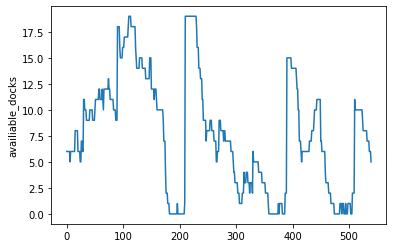

In [9]:
_ = sns.lineplot(data=df_conso, x=df_conso.index, y="availiable_docks")

### C. Train/Test Preprocessing

In [10]:
# Doing a slit of aust between train and test
split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
test = time_serie[int(round(len(time_serie)*split_ratio,0)):]
print("Split train/test ration:",round(split_ratio,2))
print("Length of dataset:", len(time_serie))
print("--------------")
print("Length of train:", len(train))
print("ratio train vs time variation:", len(train)/(time_variation*2))
print("Length of test:", len(test))
print("ratio test vs time variation:", len(test)/(time_variation*2))
print("--------------")
print("Check:", len(time_serie)-len(train)-len(test))

Split train/test ration: 0.89
Length of dataset: 540
--------------
Length of train: 480
ratio train vs time variation: 8.0
Length of test: 60
ratio test vs time variation: 1.0
--------------
Check: 0


## III. Grid-searching the best ETS parameters

### A. Function definitions for proper grid-search

Code heavily inspired from Jason Brownlee

In [11]:
# This will be our performance indicator
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', 'additive', None]
    d_params = [True, False]
    s_params = ['add', 'mul', 'additive', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            t,d,s,p,b,r = configurations[i]
            
            # define model
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
           
            # predict n values, the length of test arry
            pred = model.predict(start=len(train)+1,end=len(test)+len(train))
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            pass
    print("best configuration:", best_config)
    print("rmse associated:", best_rmse)
    return(best_config, best_rmse)

In [12]:
# Creating list of configuration possible
cfg_list = exp_smoothing_configs(seasonal=[time_variation*2])

# Sample
cfg_list[:5]

[['add', True, 'add', 60, True, True],
 ['add', True, 'add', 60, True, False],
 ['add', True, 'add', 60, False, True],
 ['add', True, 'add', 60, False, False],
 ['add', True, 'mul', 60, True, True]]

### B. Finding the best parameters over one periode

In [13]:
best_parameters, best_rmse = exp_smoothing_forecast_grid_search(train, test, cfg_list)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: Converge

best configuration: ['add', False, None, 60, False, False]
rmse associated: 6.2008063991709985


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [14]:
print("Best parameters:",best_parameters)
print("Best RMSE:", round(best_rmse,2))

Best parameters: ['add', False, None, 60, False, False]
Best RMSE: 6.2


In [15]:
# Loading the best parameters found befor
t,d,s,p,b,r = best_parameters

# Creating the model on full time serie
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

# Saving the prediction for further use
pred_first_run = model.predict(len(train)+1,len(train)+len(test))

### C. Training on full time serie to optimize before prediction

In [16]:
# Creating the model on full time serie, using best parameters
model = ExponentialSmoothing(time_serie, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

# predicting on all time serie for global RMSE
pred_model = model.predict(1,end=len(time_serie))
print("Optmised RMSE:", measure_rmse(time_serie,pred_model))

Optmised RMSE: 0.0


## IV - Making the prediction up to the time variation and creating  assessment dataframe

In [17]:
# Prediction the dataset + time variation
final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))

# Creating a dataframe for assessement
df_assessement = pd.DataFrame(columns=["actual","forecast_first_run","forecast_optimized","forecast_optimized_round"])
# Setting actual at the last known value
df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
# Setting forecast at time_serie for the past and the final prediction for the futur
df_assessement.forecast_first_run = (np.concatenate((train, pred_first_run, (np.zeros(time_variation)+pred_first_run[-1:])), axis = 0))
df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
df_assessement["date"] = df_conso["date"]
df_assessement.head()

,actual,forecast_first_run,forecast_optimized,forecast_optimized_round,date
0,6.0,6.0,6.0,6.0,2020-01-16 09:01:00
1,6.0,6.0,6.0,6.0,2020-01-16 09:02:00
2,6.0,6.0,6.0,6.0,2020-01-16 09:03:00
3,6.0,6.0,6.0,6.0,2020-01-16 09:04:00
4,6.0,6.0,6.0,6.0,2020-01-16 09:05:00


In [18]:
# Making a synthetic dataset for easier visualisation

df_assessement_small = df_assessement[-time_variation*2:]
start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

print("Start time:",start_date)
print("End time:", end_date)

index_date = pd.date_range(start=start_date, end=end_date, freq="T")
df_assessement_small.index = index_date
df_assessement_small.pop("date")
df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
df_assessement_small.head()

Start time: 2020-01-29 08:31:00
End time: 2020-01-29 09:30:00


/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,actual,forecast_first_run,forecast_optimized,forecast_optimized_round,day_before
2020-01-29 08:31:00,11.0,0.0,11.0,11.0,7.0
2020-01-29 08:32:00,10.0,0.0,10.0,10.0,7.0
2020-01-29 08:33:00,10.0,0.0,10.0,10.0,6.0
2020-01-29 08:34:00,10.0,0.0,10.0,10.0,6.0
2020-01-29 08:35:00,10.0,0.0,10.0,10.0,6.0


## V - Graphic Prediction

### A. Graphic Prepration

In [19]:
# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

In [20]:
# Calculating lower and upper bounds for ulterior use

lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)

### B. Full Prediction

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


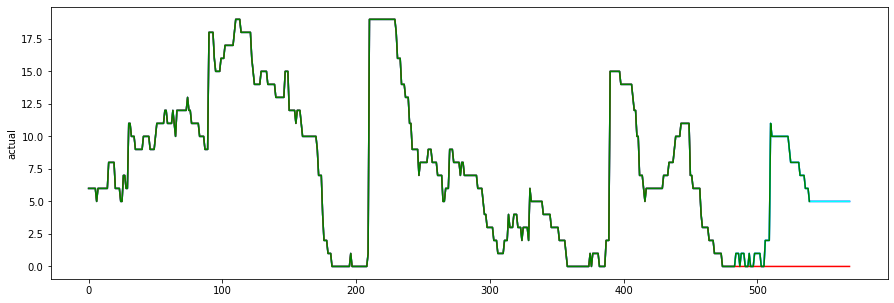

In [21]:
# Graphic visualisation of the prediction

#Removing actual data on projection time for better visualisation
df_assessement.actual[-time_variation:] = None

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x=df_assessement.index, y="forecast_optimized",data=df_assessement, color="blue")
sns.lineplot(x=df_assessement.index, y="forecast_optimized_round",data=df_assessement, color="cyan")
sns.lineplot(x=df_assessement.index, y="forecast_first_run",data=df_assessement, color="red")
sns.lineplot(x=df_assessement.index, y="actual",data=df_assessement, color="green")

plt.show()

### C. Synthetic visualisation of results

/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/home/exalis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/exalis/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you t

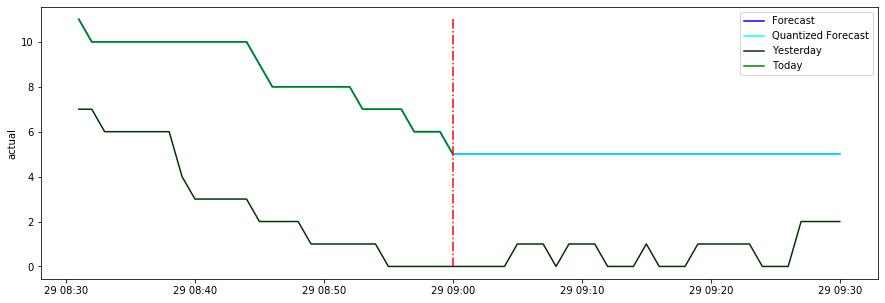

In [22]:
# Setting prediction boundary


#Removing actual data on projection time for better visualisation
df_assessement_small.actual[-time_variation:] = None

# Graphic visualisation of the prediction
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="cyan",label="Quantized Forecast")
ax = sns.lineplot(x=df_assessement_small.index, y="day_before",data=df_assessement_small, color="#003300",label="Yesterday")
ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today")


x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
ax = plt.plot(x1, y1, linestyle="dashdot", color="red")


plt.show()